# Project 2 - Team 22
Christina Acojedo, Mrinal Gupta, 
Athanasios Rompokos, Guyane Valian, Min Zhu


In [0]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import itertools
from typing import List
import time
from scipy import stats
from scipy.stats import zscore
import random
import sys

%matplotlib inline
start_time = pd.datetime.now()

In [0]:
import psutil

from IPython.display import display

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

%matplotlib inline

## Function Definition Area
### Optimize Data Fields
This function is used to reduce the size of the dataframes to enable our laptops to run parts of the code more efficiently. When using this function, it may take a while for a dataframe to be processed. 

#### Reference
https://medium.com/bigdatarepublic/advanced-pandas-optimize-speed-and-memory-a654b53be6c2

https://pythonspeed.com/articles/pandas-load-less-data/

In [0]:
def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df



def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))

read the dataset

In [0]:
df = pd.read_csv('applications data.csv', parse_dates = ["date"]) # read the dataset 

## Data Imputation
Replace the frivolous values with the record number.

In [0]:
# Replace all frivolous values with the record number.
start = pd.datetime.now()
df['ssn'] = np.where(df['ssn'] == 999999999, df['record'], df['ssn'])
df['address'] = np.where(df['address'] == "123 MAIN ST", df['record'], df['address'])
df['dob'] = np.where(df['dob'] == 19070626, df['record'], df['dob'])
df['homephone'] = np.where(df['homephone'] == 9999999999, df['record'], df['homephone'])
print(pd.datetime.now() - start)

0:00:00.134641


# Variable Creation
## Categorical Candidate Variables

In [0]:
start_convert = pd.datetime.now()
df_var = deepcopy(df)

# Convert values to string type so that we can concatenate some of them together to make variables
cols_convert = [df_var.columns.drop(['date','fraud_label'])] # Don't convert the date or fraud label
for item in cols_convert:
    df_var[item] = df_var[item].astype(str)

print('convert time', pd.datetime.now()-start_convert)
df_var.dtypes

convert time 0:00:03.338103


record                 object
date           datetime64[ns]
ssn                    object
firstname              object
lastname               object
address                object
zip5                   object
dob                    object
homephone              object
fraud_label             int64
dtype: object

In [0]:
# Make combinations with the name
df_var['fullname'] = df_var['firstname'] + df_var['lastname']
df_var['fullname-dob'] = df_var['fullname'] + df_var['dob']
df_var['fullname-ssn'] = df_var['fullname'] + df_var['ssn'] 
df_var['fullname-homephone'] = df_var['fullname'] + df_var['homephone'] 
df_var['fullname-address'] = df_var['fullname'] + df_var['address'] 
df_var['fullname-address-zip'] = df_var['fullname'] + df_var['address'] + df_var['zip5']
df_var['fullname-dob-homephone'] = df_var['fullname'] + df_var['dob'] + df_var['homephone'] 
df_var['fullname-dob-zip'] = df_var['fullname'] + df_var['dob'] + df_var['zip5']
df_var['fullname-zip'] = df_var['fullname'] + df_var['zip5'] 
df_var['firstname-dob'] = df_var['firstname'] + df_var['dob']  
df_var['lastname-dob'] = df_var['lastname'] + df_var['dob']  
df_var['firstname-homephone'] = df_var['firstname'] + df_var['homephone']  
df_var['lastname-homephone'] = df_var['lastname'] + df_var['homephone']  

In [0]:
# Make combinations with the ssn
df_var['ssn-firstname'] = df_var['ssn'] + df_var['firstname'] 
df_var['ssn-lastname'] = df_var['ssn'] + df_var['lastname'] 
df_var['ssn-zip'] = df_var['ssn'] + df_var['zip5'] 
df_var['ssn-dob'] = df_var['ssn'] + df_var['dob'] 
df_var['ssn-homephone'] = df_var['ssn'] + df_var['homephone'] 
df_var['ssn-address'] = df_var['ssn'] + df_var['address'] 
df_var['ssn-address-zip'] = df_var['ssn'] + df_var['address'] + df_var['zip5'] 
df_var['ssn-fullname-dob'] = df_var['ssn'] + df_var['fullname'] + df_var['dob'] 

In [0]:
# Make combinations of other data fields
df_var['address-zip'] = df_var['address'] + df_var['zip5']  
df_var['address-zip-fullname-dob'] = df_var['address'] + df_var['zip5'] + df_var['fullname'] + df_var['dob']
df_var['address-zip-homephone'] = df_var['address'] + df_var['zip5'] + df_var['homephone']
df_var['zip-homephone'] = df_var['zip5'] + df_var['homephone']
df_var['zip-dob'] = df_var['zip5'] + df_var['dob']  
df_var['homephone-dob'] = df_var['homephone'] + df_var['dob']  

### Convert Data Types
Convert strings back to integers where possible.

In [0]:
# Convert appropriate data fields back to integers for faster processing later in the code
start_convert=pd.datetime.now()

cols_int = ['record','ssn','zip5','dob','homephone','zip']
cols_var = df_var.columns

for item in cols_var:
    temp = set(item.split('-'))
#     print(temp)
    if temp.issubset(cols_int):
        try:
            df_var[item] = df_var[item].astype('int64')
        except:
            print('The values are probably too big:', item)
            continue

print('convert time', pd.datetime.now()-start_convert)
df_var.dtypes

The values are probably too big: ssn-homephone
convert time 0:00:01.222173


record                               int64
date                        datetime64[ns]
ssn                                  int64
firstname                           object
lastname                            object
address                             object
zip5                                 int64
dob                                  int64
homephone                            int64
fraud_label                          int64
fullname                            object
fullname-dob                        object
fullname-ssn                        object
fullname-homephone                  object
fullname-address                    object
fullname-address-zip                object
fullname-dob-homephone              object
fullname-dob-zip                    object
fullname-zip                        object
firstname-dob                       object
lastname-dob                        object
firstname-homephone                 object
lastname-homephone                  object
ssn-firstna

## Numerical Candidate Variables
### Create Columns for the Necessary Time Periods
This makes new columns for the various time periods.

In [0]:
# Make a list of variable combinations to iterate through and create time-related variables
cols_drop = ['record','date','firstname','lastname','zip5','fraud_label']
var_combos = df_var.drop(cols_drop,axis=1).columns

# Create column names
time_list = [0,1,3,7,14,30,90,180]
time_joined =['join_ts1']
for num in time_list:
    time_joined.append('join_ts2_'+str(num))
    
start_copy = pd.datetime.now()
df_var1 = deepcopy(df_var)
df_var2 = deepcopy(df_var)
print('copy time', pd.datetime.now()-start_copy)

# Creating columns for time
start_loop=pd.datetime.now()
df_var2['join_ts1'] = df_var2['date']
for time in time_list:
    temp_endTime = 'join_ts2_' + str(time)
    df_var2[temp_endTime] = df_var2['date'] + dt.timedelta(time)
print('first loop', pd.datetime.now()-start_loop)

copy time 0:00:00.741051
first loop 0:00:00.217412


### Velocity Candidate Variables
This makes the velocity variables. It's counting the number of applications (records) it sees based on the time period. For instance, it counts all the applications for an SSN it sees over the last 3 days based on the date and record number. It only counts the current record and those records in the past for those last 3 days.

In [0]:
start_loop2=pd.datetime.now()
df_final = deepcopy(df_var.set_index('record'))

for item in var_combos:
    df_var3 = df_var1[['record','date',item]]
    temp_list = time_joined + [item]
    df_var4 = df_var2[temp_list + ['record']].copy()
    df_var4.rename(columns={'record':'record2'},inplace=True) 
    
    df_temp = pd.merge(df_var3, df_var4, left_on=[item], right_on=[item])

    for time in time_list:
        temp_endTime = 'join_ts2_' + str(time)
        df2_temp = df_temp[(df_temp['date'] <= df_temp[temp_endTime]) & (df_temp['record2'] <= df_temp['record'])]
        
        temp_groupby = df2_temp[['record','date']].groupby('record')
        
        temp_name = item + '_' + 'velocity' + str(time) + '_'
        df_final = pd.merge(df_final, getattr(temp_groupby,'count')().add_prefix(temp_name), left_index=True, right_index=True, how='left')

print('second loop', pd.datetime.now()-start_loop2)
print(len(df_final.columns))
df_final.head()

second loop 0:09:55.765871
284


date        ssn  firstname  lastname        address   zip5       dob   homephone  fraud_label           fullname               fullname-dob                fullname-ssn           fullname-homephone                fullname-address                 fullname-address-zip               fullname-dob-homephone                fullname-dob-zip            fullname-zip      firstname-dob      lastname-dob  firstname-homephone  lastname-homephone       ssn-firstname       ssn-lastname         ssn-zip            ssn-dob        ssn-homephone             ssn-address              ssn-address-zip                    ssn-fullname-dob         address-zip                     address-zip-fullname-dob         address-zip-homephone    zip-homephone        zip-dob       homephone-dob  ssn_velocity0_date  ssn_velocity1_date  ssn_velocity3_date  ssn_velocity7_date  ssn_velocity14_date  ssn_velocity30_date  ssn_velocity90_date  ssn_velocity180_date  address_velocity0_date  address_velocity1_date  \
record                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
1      2016-01-01  379070012   XRRAMMTR  SMJETJMJ  6861 EUTST PL   2765         1  1797504115            0   XRRAMMTRSMJETJMJ          XRRAMMTRSMJETJMJ1   XRRAMMTRSMJETJMJ379070012   XRRAMMTRSMJETJMJ1797504115   XRRAMMTRSMJETJMJ6861 EUTST PL    XRRAMMTRSMJETJMJ6861 EUTST PL2765          XRRAMMTRSMJETJMJ11797504115           XRRAMMTRSMJETJMJ12765    XRRAMMTRSMJETJMJ2765          XRRAMMTR1         SMJETJMJ1   XRRAMMTR1797504115  SMJETJMJ1797504115   379070012XRRAMMTR  379070012SMJETJMJ   3790700122765         3790700121  3790700121797504115  3790700126861 EUTST PL   3790700126861 EUTST PL2765          379070012XRRAMMTRSMJETJMJ1   6861 EUTST PL2765           6861 EUTST PL2765XRRAMMTRSMJETJMJ1   6861 EUTST PL27651797504115   27651797504115          27651         17975041151                   1                   1                   1                   1                    1                    1                    1                     1                       1                       1   
2      2016-01-01  387482503   MAMSTUJR  RTTEMRRR  7280 URASA PL  57169  19340615  4164239415            1   MAMSTUJRRTTEMRRR   MAMSTUJRRTTEMRRR19340615   MAMSTUJRRTTEMRRR387482503   MAMSTUJRRTTEMRRR4164239415   MAMSTUJRRTTEMRRR7280 URASA PL   MAMSTUJRRTTEMRRR7280 URASA PL57169   MAMSTUJRRTTEMRRR193406154164239415   MAMSTUJRRTTEMRRR1934061557169   MAMSTUJRRTTEMRRR57169   MAMSTUJR19340615  RTTEMRRR19340615   MAMSTUJR4164239415  RTTEMRRR4164239415   387482503MAMSTUJR  387482503RTTEMRRR  38748250357169  38748250319340615  3874825034164239415  3874825037280 URASA PL  3874825037280 URASA PL57169   387482503MAMSTUJRRTTEMRRR19340615  7280 URASA PL57169   7280 URASA PL57169MAMSTUJRRTTEMRRR19340615  7280 URASA PL571694164239415  571694164239415  5716919340615  416423941519340615                   1                   1                   1                   1                    1                    1                    1                     1                       1                       1   
3      2016-01-01  200332

### Relativey Velocity Candidate Variables
This is making the relative velocity variables. 

num apps with that group seen in the recent past / num apps with that same group seen in the past 1, 3, 7, 14, 30, etc. days / num days


In [0]:
# Save the results from the previous loop before sending the df_final dataframe through the 3rd loop
df_final_loop2 = deepcopy(df_final)

In [0]:
start_loop3=pd.datetime.now()
groupbyvar_denom = deepcopy(var_combos)
days_numer = ['0','1']
days_denom = ['3','7','14','30','90','180']

for b in groupbyvar_denom:
    for c in days_numer:
        for d in days_denom:
            temp = d
            df_final[b + '_' + c + '_dayvel' + '_div_' + d + '_dayvel' + '_relvelocity'] = \
                df_final[b + '_velocity' + c + '_date'] / \
                df_final[b + '_velocity' + d + '_date'] / float(temp)
print('third loop', pd.datetime.now() - start_loop3)

third loop 0:00:17.563130


### "Days Since" Candidate Variables
Find the number of days since we last saw each variable.

In [0]:
# Prof's notebook code for the Days-Since variables 
# function to find days since variables
def ds(dataframe, g1, g2, name):
#     'Helps with calculating the day since variables'
    day_since = dataframe.groupby(g1)[g1].first()
    day_since = day_since.rename_axis(['None' for i in range(len(g1))]).groupby(g2).diff()
    day_since.columns = [name]
    day_since = day_since.rename_axis(g1)
    day_since[name] = day_since[name].dt.days.fillna(0)
    day_since = day_since.reset_index()
    return day_since

In [0]:
time_ds_all=pd.datetime.now()
# Iterate through all the variables and send them through the "ds" function to find the "days since" values
ds_dict={}
for item in var_combos:
    curr_time=pd.datetime.now()
    
    # Determine the days-since variable to calculate and its name
    groupby_cols2 = item.split('-')
    groupby_cols1 = groupby_cols2 + ['date']
    curr_name = item + '_daysSince'

    # Calculate the days-since variable (ds) and assign it to a global variable (curr_name)
    try:
        vars()[curr_name] = ds(df_var, groupby_cols1, groupby_cols2, curr_name)
        ds_dict[curr_name] = vars()[curr_name] # Save results to a dictionary
    except KeyError:
        zip_index1 = groupby_cols1.index('zip')
        groupby_cols1[zip_index1] = 'zip5'
        zip_index2 = groupby_cols2.index('zip')
        groupby_cols2[zip_index2] = 'zip5'
        
        vars()[curr_name] = ds(df_var, groupby_cols1, groupby_cols2, curr_name)
        ds_dict[curr_name] = vars()[curr_name] # Save results to a dictionary
    except:
        print("ERROR INFO ->", sys.exc_info()[0],sys.exc_info()[1])
        
    print("Done with:", item, "; Time:", pd.datetime.now()-curr_time)
    
print("DONE WITH ALL!", pd.datetime.now()-time_ds_all)

Done with: ssn ; Time: 0:08:40.198178
Done with: address ; Time: 0:07:31.422888
Done with: dob ; Time: 0:01:38.012474
Done with: homephone ; Time: 0:01:04.350546
Done with: fullname ; Time: 0:06:26.392157
Done with: fullname-dob ; Time: 0:09:41.888659
Done with: fullname-ssn ; Time: 0:09:37.210716
Done with: fullname-homephone ; Time: 0:09:38.585639
Done with: fullname-address ; Time: 0:08:59.794520
Done with: fullname-address-zip ; Time: 0:11:16.829489
Done with: fullname-dob-homephone ; Time: 0:11:37.190578
Done with: fullname-dob-zip ; Time: 0:12:09.923545
Done with: fullname-zip ; Time: 0:10:00.227703
ERROR INFO -> <class 'MemoryError'> Unable to allocate 17.6 TiB for an array with shape (4826663873600,) and data type int32
Done with: firstname-dob ; Time: 0:36:04.152866
ERROR INFO -> <class 'MemoryError'> Unable to allocate 39.8 TiB for an array with shape (10933811972600,) and data type int32
Done with: lastname-dob ; Time: 0:36:25.748976
ERROR INFO -> <class 'MemoryError'> Unabl

In our original project we used the days since vars from the notebook given to us by the professor. We subsequently refined the code; the cell below should be able to merge the days since variables with the rest of the df_final. Please note we were unable to fully test the cell below due to memory limitations.  

In [0]:
time_ds_merge=pd.datetime.now()

# Merge the days-since variables with the main dataset
for item in ds_dict.keys():
    col_variable = item.split('_')[0]
    print(col_variable)
    try: 
        df_final = pd.merge(df_final, ds_dict[item], how='left', left_on=[col_variable,'date'], right_on=[col_variable,'date'])
        
    except KeyError:
        right_col_variable = col_variable.split('-')
        
        if 'zip' in right_col_variable:
            zip_index = right_col_variable.index('zip')
            right_col_variable[zip_index] = 'zip5'
        
        temp = ds_dict[item].copy()
        temp[col_variable]=temp[right_col_variable].astype(str).sum(axis=1)
        temp.drop(columns=right_col_variable, inplace=True)
        temp = optimize(temp)
        df_final = pd.merge(df_final, temp, how='left', left_on=[col_variable,'date'], right_on=[col_variable,'date'])
        
    except:
        print("ERROR INFO ->", sys.exc_info()[0],sys.exc_info()[1])

print("DONE WITH ALL!", pd.datetime.now()-time_ds_merge)

# Variable Selection
## Scale all variables (typically z scale)

In [0]:
# Get only the numerical variables
numerical_index = df_final.columns.get_loc("homephone-dob")+1 #this is the index of the first numerical feature/column in the dataframe
df_numerical = pd.concat([df_final['fraud_label'],df_final.iloc[:,numerical_index:]], axis=1)

In [0]:
# Add a variable full of random numbers
df_numerical.insert(1, 'rand_num', random.sample(range(1, 4000000), len(df_numerical)))
df_numerical.head()

fraud_label  rand_num  ssn_velocity0_date  ssn_velocity1_date  ssn_velocity3_date  ssn_velocity7_date  ssn_velocity14_date  ssn_velocity30_date  ssn_velocity90_date  ssn_velocity180_date  address_velocity0_date  address_velocity1_date  address_velocity3_date  address_velocity7_date  address_velocity14_date  address_velocity30_date  address_velocity90_date  address_velocity180_date  dob_velocity0_date  dob_velocity1_date  dob_velocity3_date  dob_velocity7_date  dob_velocity14_date  dob_velocity30_date  dob_velocity90_date  dob_velocity180_date  homephone_velocity0_date  homephone_velocity1_date  homephone_velocity3_date  homephone_velocity7_date  homephone_velocity14_date  homephone_velocity30_date  homephone_velocity90_date  homephone_velocity180_date  fullname_velocity0_date  fullname_velocity1_date  fullname_velocity3_date  fullname_velocity7_date  fullname_velocity14_date  fullname_velocity30_date  fullname_velocity90_date  fullname_velocity180_date  \
0            0   2233576                   1                   1                   1                   1                    1                    1                    1                     1                       1                       1                       1                       1                        1                        1                        1                         1                   1                   1                   1                   1                    1                    1                    1                     1                         1                         1                         1                         1                          1                          1                          1                           1                        1                        1                        1                        1                         1                         1                         1                          1   
1            1    353094                   1                   1                   1                   1                    1                    1                    1                     1                       1                       1                       1                       1                        1                        1                        1                         1                   1                   1                   1                   1                    1                    1                    1                     1                         1                         1                         1                         1                          1                          1                          1                           1                        1                        1                        1                        1                         1                         1                         1                          1   
2            0   2221122                   1                   1                   1                   1                    1                    1                    1                     1                       1                       1                       1                       1                        1                        1                        1                         1                   1                   1                   1                   1                    1                    1                    1                     1                         1                         1                         1                         1                          1                          1                          1                           1                        1                        1                        1                        1                         1                         1                         1                          1   
3            0    178836                   1                   1                   1                   1       

In [0]:
# Flip the "Days Since" variables (max of col - current value)
days_since_cols = df_numerical.columns[-14:]

for col in days_since_cols:
    max_val = df_numerical[col].max()
    df_numerical[col] = max_val - df_numerical[col]

In [0]:
df_numerical.head()

fraud_label  rand_num  ssn_velocity0_date  ssn_velocity1_date  ssn_velocity3_date  ssn_velocity7_date  ssn_velocity14_date  ssn_velocity30_date  ssn_velocity90_date  ssn_velocity180_date  address_velocity0_date  address_velocity1_date  address_velocity3_date  address_velocity7_date  address_velocity14_date  address_velocity30_date  address_velocity90_date  address_velocity180_date  dob_velocity0_date  dob_velocity1_date  dob_velocity3_date  dob_velocity7_date  dob_velocity14_date  dob_velocity30_date  dob_velocity90_date  dob_velocity180_date  homephone_velocity0_date  homephone_velocity1_date  homephone_velocity3_date  homephone_velocity7_date  homephone_velocity14_date  homephone_velocity30_date  homephone_velocity90_date  homephone_velocity180_date  fullname_velocity0_date  fullname_velocity1_date  fullname_velocity3_date  fullname_velocity7_date  fullname_velocity14_date  fullname_velocity30_date  fullname_velocity90_date  fullname_velocity180_date  \
0            0   2233576                   1                   1                   1                   1                    1                    1                    1                     1                       1                       1                       1                       1                        1                        1                        1                         1                   1                   1                   1                   1                    1                    1                    1                     1                         1                         1                         1                         1                          1                          1                          1                           1                        1                        1                        1                        1                         1                         1                         1                          1   
1            1    353094                   1                   1                   1                   1                    1                    1                    1                     1                       1                       1                       1                       1                        1                        1                        1                         1                   1                   1                   1                   1                    1                    1                    1                     1                         1                         1                         1                         1                          1                          1                          1                           1                        1                        1                        1                        1                         1                         1                         1                          1   
2            0   2221122                   1                   1                   1                   1                    1                    1                    1                     1                       1                       1                       1                       1                        1                        1                        1                         1                   1                   1                   1                   1                    1                    1                    1                     1                         1                         1                         1                         1                          1                          1                          1                           1                        1                        1                        1                        1                         1                         1                         1                          1   
3            0    178836                   1                   1                   1                   1       

In [0]:
# z-scale the numerical variables
df_numerical_zscale = df_numerical.apply(zscore)
df_numerical_zscale['fraud_label'] = df_numerical['fraud_label']
df_numerical_zscale.head(100)

fraud_label  rand_num  ssn_velocity0_date  ssn_velocity1_date  ssn_velocity3_date  ssn_velocity7_date  ssn_velocity14_date  ssn_velocity30_date  ssn_velocity90_date  ssn_velocity180_date  address_velocity0_date  address_velocity1_date  address_velocity3_date  address_velocity7_date  address_velocity14_date  address_velocity30_date  address_velocity90_date  address_velocity180_date  dob_velocity0_date  dob_velocity1_date  dob_velocity3_date  dob_velocity7_date  dob_velocity14_date  dob_velocity30_date  dob_velocity90_date  dob_velocity180_date  homephone_velocity0_date  homephone_velocity1_date  homephone_velocity3_date  homephone_velocity7_date  homephone_velocity14_date  homephone_velocity30_date  homephone_velocity90_date  homephone_velocity180_date  fullname_velocity0_date  fullname_velocity1_date  fullname_velocity3_date  fullname_velocity7_date  fullname_velocity14_date  fullname_velocity30_date  fullname_velocity90_date  fullname_velocity180_date  \
0             0  0.203390           -0.032706           -0.039149           -0.047591           -0.058092            -0.072421             -0.09901            -0.158192             -0.185893               -0.042158               -0.051076               -0.060819               -0.072633                -0.088541                -0.117706                -0.182093                 -0.210277           -0.117279           -0.139483           -0.143138            -0.14309            -0.142504             -0.14132             -0.13755             -0.131796                 -0.194849                 -0.321837                 -0.521454                 -0.769214                  -1.011308                  -1.256308                  -1.400192                   -1.307043                -0.041974                -0.055282                -0.079503                -0.115648                 -0.159376                 -0.211201                 -0.248092                  -0.246266   
1             1 -1.425404           -0.032706           -0.039149           -0.047591           -0.058092            -0.072421             -0.09901            -0.158192             -0.185893               -0.042158               -0.051076               -0.060819               -0.072633                -0.088541                -0.117706                -0.182093                 -0.210277           -0.117279           -0.139483           -0.143138            -0.14309            -0.142504             -0.14132             -0.13755             -0.131796                 -0.194849                 -0.321837                 -0.521454                 -0.769214                  -1.011308                  -1.256308                  -1.400192                   -1.307043                -0.041974                -0.055282                -0.079503                -0.115648                 -0.159376                 -0.211201                 -0.248092                  -0.246266   
2             0  0.192602           -0.032706           -0.039149           -0.047591           -0.058092            -0.072421             -0.09901            -0.158192             -0.185893               -0.042158               -0.051076               -0.060819               -0.072633                -0.088541                -0.117706                -0.182093                 -0.210277           -0.117279           -0.139483           -0.143138            -0.14309            -0.142504             -0.14132             -0.13755             -0.131796                 -0.194849                 -0.321837                 -0.521454                 -0.769214                  -1.011308                  -1.256308                  -1.400192                   -1.307043                -0.041974                -0.055282                -0.079503                -0.115648                 -0.159376                 -0.211201                 -0.248092                  -0.246266   
3             0 -1.576339           -0.032706           -0.039149           -0.047591           -0.058092   

In [0]:
# verify there are no NaN values
df_numerical_zscale[df_numerical_zscale.isna().any(axis=1)]

Empty DataFrame
Columns: [fraud_label, rand_num, ssn_velocity0_date, ssn_velocity1_date, ssn_velocity3_date, ssn_velocity7_date, ssn_velocity14_date, ssn_velocity30_date, ssn_velocity90_date, ssn_velocity180_date, address_velocity0_date, address_velocity1_date, address_velocity3_date, address_velocity7_date, address_velocity14_date, address_velocity30_date, address_velocity90_date, address_velocity180_date, dob_velocity0_date, dob_velocity1_date, dob_velocity3_date, dob_velocity7_date, dob_velocity14_date, dob_velocity30_date, dob_velocity90_date, dob_velocity180_date, homephone_velocity0_date, homephone_velocity1_date, homephone_velocity3_date, homephone_velocity7_date, homephone_velocity14_date, homephone_velocity30_date, homephone_velocity90_date, homephone_velocity180_date, fullname_velocity0_date, fullname_velocity1_date, fullname_velocity3_date, fullname_velocity7_date, fullname_velocity14_date, fullname_velocity30_date, fullname_velocity90_date, fullname_velocity180_date, fullname-dob_velocity0_date, fullname-dob_velocity1_date, fullname-dob_velocity3_date, fullname-dob_velocity7_date, fullname-dob_velocity14_date, fullname-dob_velocity30_date, fullname-dob_velocity90_date, fullname-dob_velocity180_date, fullname-ssn_velocity0_date, fullname-ssn_velocity1_date, fullname-ssn_velocity3_date, fullname-ssn_velocity7_date, fullname-ssn_velocity14_date, fullname-ssn_velocity30_date, fullname-ssn_velocity90_date, fullname-ssn_velocity180_date, fullname-homephone_velocity0_date, fullname-homephone_velocity1_date, fullname-homephone_velocity3_date, fullname-homephone_velocity7_date, fullname-homephone_velocity14_date, fullname-homephone_velocity30_date, fullname-homephone_velocity90_date, fullname-homephone_velocity180_date, fullname-address_velocity0_date, fullname-address_velocity1_date, fullname-address_velocity3_date, fullname-address_velocity7_date, fullname-address_velocity14_date, fullname-address_velocity30_date, fullname-address_velocity90_date, fullname-address_velocity180_date, fullname-address-zip_velocity0_date, fullname-address-zip_velocity1_date, fullname-address-zip_velocity3_date, fullname-address-zip_velocity7_date, fullname-address-zip_velocity14_date, fullname-address-zip_velocity30_date, fullname-address-zip_velocity90_date, fullname-address-zip_velocity180_date, fullname-dob-homephone_velocity0_date, fullname-dob-homephone_velocity1_date, fullname-dob-homephone_velocity3_date, fullname-dob-homephone_velocity7_date, fullname-dob-homephone_velocity14_date, fullname-dob-homephone_velocity30_date, fullname-dob-homephone_velocity90_date, fullname-dob-homephone_velocity180_date, fullname-dob-zip_velocity0_date, fullname-dob-zip_velocity1_date, fullname-dob-zip_velocity3_date, fullname-dob-zip_velocity7_date, fullname-dob-zip_velocity14_date, fullname-dob-zip_velocity30_date, fullname-dob-zip_velocity90_date, fullname-dob-zip_velocity180_date, fullname-zip_velocity0_date, fullname-zip_velocity1_date, ...]
Index: []

[0 rows x 636 columns]

In [0]:
df_numerical_zscale = optimize(df_numerical_zscale)
df_numerical_zscale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 636 entries, fraud_label to lastnamessn_diff
dtypes: float32(635), int8(1)
memory usage: 2.4 GB


In [0]:
# df_numerical_zscale.to_csv('df_numerical_zscale.csv')

## Separate data into modeling/Out of Time (OOT)

In [0]:
df_oot = df_numerical_zscale.loc[(df_final['date'] >= '2016-11-01')]
df_modeling_scaled = df_numerical_zscale.loc[((df_final['date'] < '2016-11-01') & (df_final['date'] > '2016-01-14'))]

In [0]:
df_modeling_scaled.head()

record       date        ssn  firstname  lastname         address   zip5       dob   homephone  fraud_label           fullname               fullname-dob                fullname-ssn           fullname-homephone                 fullname-address                  fullname-address-zip               fullname-dob-homephone                fullname-dob-zip            fullname-zip       ssn-firstname       ssn-lastname         ssn-zip            ssn-dob        ssn-homephone              ssn-address               ssn-address-zip                    ssn-fullname-dob          address-zip                      address-zip-fullname-dob          address-zip-homephone    zip-homephone        zip-dob       homephone-dob      firstname-dob      lastname-dob  firstname-homephone  lastname-homephone  ssn_velocity0_date  ssn_velocity1_date  ssn_velocity3_date  ssn_velocity7_date  ssn_velocity14_date  ssn_velocity30_date  ssn_velocity90_date  ssn_velocity180_date  address_velocity0_date  \
38511   38512 2016-01-15  476774243   RASTAZMM  EEJTAXEZ   1420 SJXAM WY  58008  19570328  7355086598            0   RASTAZMMEEJTAXEZ   RASTAZMMEEJTAXEZ19570328   RASTAZMMEEJTAXEZ476774243   RASTAZMMEEJTAXEZ7355086598    RASTAZMMEEJTAXEZ1420 SJXAM WY    RASTAZMMEEJTAXEZ1420 SJXAM WY58008   RASTAZMMEEJTAXEZ195703287355086598   RASTAZMMEEJTAXEZ1957032858008   RASTAZMMEEJTAXEZ58008   476774243RASTAZMM  476774243EEJTAXEZ  47677424358008  47677424319570328  4767742437355086598   4767742431420 SJXAM WY   4767742431420 SJXAM WY58008   476774243RASTAZMMEEJTAXEZ19570328   1420 SJXAM WY58008    1420 SJXAM WY58008RASTAZMMEEJTAXEZ19570328   1420 SJXAM WY580087355086598  580087355086598  5800819570328  735508659819570328   RASTAZMM19570328  EEJTAXEZ19570328   RASTAZMM7355086598  EEJTAXEZ7355086598                   1                   1                   1                   1                    1                    1                    1                     1                       1   
38512   38513 2016-01-15  432844033    ESXAURS  SMJZXZMZ  2314 SZSRJ AVE  60458  19850530   837788477            0    ESXAURSSMJZXZMZ    ESXAURSSMJZXZMZ19850530    ESXAURSSMJZXZMZ432844033     ESXAURSSMJZXZMZ837788477    ESXAURSSMJZXZMZ2314 SZSRJ AVE    ESXAURSSMJZXZMZ2314 SZSRJ AVE60458     ESXAURSSMJZXZMZ19850530837788477    ESXAURSSMJZXZMZ1985053060458    ESXAURSSMJZXZMZ60458    432844033ESXAURS  432844033SMJZXZMZ  43284403360458  43284403319850530   432844033837788477  4328440332314 SZSRJ AVE  4328440332314 SZSRJ AVE60458    432844033ESXAURSSMJZXZMZ19850530  2314 SZSRJ AVE60458    2314 SZSRJ AVE60458ESXAURSSMJZXZMZ19850530   2314 SZSRJ AVE60458837788477   60458837788477  6045819850530   83778847719850530    ESXAURS19850530  SMJZXZMZ19850530     ESXAURS837788477   SMJZXZMZ837788477                   1                   1                   1                   1                    1                    1                    1                     1                       1   
38513   38514 2016-01-15  185477074  XMAEAEXSX  RTZRTZAS  9310 RMZTT AVE  65654  19180130  9130092903            0  XMAEAEXSXRTZRTZAS  XMAEAEXSXRTZRTZAS19180130  XMAEAEXSXRTZRTZAS185477074  XMAEAEXSXRTZRTZAS9130092903  XMAEAEXSXRTZRTZAS9310 RMZTT AVE  XMAEAEXSXRTZRTZAS9310 RMZTT AVE65654  XMAEAEXSXRTZRTZAS191801309130092903  XMAEAEXSXRTZRTZAS1918013065654  XMAEAEXSXRTZRTZAS65654  185477074XMAEAEXSX  185477074RTZRTZAS  18547707465654  18547707419180130  1854770749130092903  1854770749310 RMZTT AVE  1854770749310 RMZTT AVE65654  185477074XMAEAEXSXRTZRTZAS19180130  9310 RMZTT AVE65654  9310 RMZTT AVE65654XMAEAEXSXRTZRTZAS19180130  9310 RMZTT AVE656549130092903  656549130092903  6565419180130  913009290319180130  XMAEAEXSX19180130  RTZRTZAS19180130  XMAEAEXSX9130092903  RTZRTZAS9130092903                   1                   1                   1                   1                    1                    1                    1                     1                       1   
38514   38515 2016-01-15  933119335  UUTXTTUAE   EMUTUJ

# Filter & Wrapper Methods


In [0]:
print('Memory percentage used',psutil.virtual_memory().percent)

Memory percentage used 76.9


#### Feature selection (filter method)

In [0]:
data_Jan14 = deepcopy(df_modeling_scaled)

In [0]:
# find good and bad indices
good_ind = np.where(data_Jan14['fraud_label'] == 0)
bad_ind = np.where(data_Jan14['fraud_label'] == 1)

In [0]:
inliers_class = data_Jan14.iloc[good_ind]
outlier_class = data_Jan14.iloc[bad_ind]

In [0]:
no_of_total_frauds = data_Jan14['fraud_label'].sum()
no_of_total_frauds

11486

In [0]:
data_Jan14.iloc[good_ind].tail()

record       ssn      zip5       dob  homephone  fraud_label   ssn-zip   ssn-dob  ssn-homephone  zip-homephone   zip-dob  homephone-dob  ssn_velocity0_date  ssn_velocity1_date  ssn_velocity3_date  ssn_velocity7_date  ssn_velocity14_date  ssn_velocity30_date  ssn_velocity90_date  ssn_velocity180_date  address_velocity0_date  address_velocity1_date  address_velocity3_date  address_velocity7_date  address_velocity14_date  address_velocity30_date  address_velocity90_date  address_velocity180_date  dob_velocity0_date  dob_velocity1_date  dob_velocity3_date  dob_velocity7_date  dob_velocity14_date  dob_velocity30_date  dob_velocity90_date  dob_velocity180_date  homephone_velocity0_date  homephone_velocity1_date  homephone_velocity3_date  homephone_velocity7_date  homephone_velocity14_date  homephone_velocity30_date  homephone_velocity90_date  homephone_velocity180_date  fullname_velocity0_date  fullname_velocity1_date  fullname_velocity3_date  fullname_velocity7_date  \
833502  833503  0.419383 -1.575062  0.466513  -0.273241            0 -1.237361  0.575598       0.629885      -1.172882 -1.240484      -0.129156           -0.032706           -0.039149           -0.047591           -0.058092            -0.072421             -0.09901             1.357098              0.942405               -0.042158               -0.051076               -0.060819               -0.072633                -0.088541                -0.117706                 0.993769                  0.660757           -0.117279           -0.139483           -0.143138           -0.143090            -0.079620            -0.049818            -0.060597             -0.051943                 -0.194849                  1.274165                  0.639149                  1.703825                   0.708788                   0.140554                   0.760883                    0.733862                -0.041974                -0.055282                -0.079503                -0.115648   
833503  833504 -1.604572  0.639394  0.375156   0.836262            0 -1.369516 -1.292136      -1.226690       0.836148  0.782540       0.932713           -0.032706           -0.039149           -0.047591           -0.058092            -0.072421             -0.09901            -0.158192              0.942405               -0.042158               -0.051076               -0.060819               -0.072633                -0.088541                -0.117706                -0.182093                  0.660757           -0.117279           -0.139483           -0.143138           -0.143090            -0.016737            -0.080319            -0.038610             -0.039657                 -0.194849                 -0.321837                  0.639149                  1.703825                   0.708788                   0.489769                   0.472739                    1.126344                -0.041974                -0.055282                -0.079503                -0.115648   
833504  833505  0.385874  0.095196  0.362550  -1.489848            0  0.517010  0.544676      -1.290671      -1.314824  0.285385      -1.293531           -0.032706           -0.039149           -0.047591           -0.058092            -0.072421             -0.09901            -0.158192             -0.185893               -0.042158               -0.051076               -0.060819               -0.072633                -0.088541                -0.117706                -0.182093                 -0.210277           -0.117279            0.419347            0.360801            0.096963            -0.016737            -0.049818            -0.104570             -0.101083                 -0.194849                 -0.321837                 -0.521454                 -0.769214                  -1.011308                  -1.256308                  -1.400192                   -1.307043                -0.041974                -0.055282                -0.079503                -0.115648   
833505  833506 -1.088515  0.277483  0.334230   1.678888     

In [0]:
print('Memory percentage used',psutil.virtual_memory().percent)

Memory percentage used 84.8


Find FDR and KS statistic for each feature


In [0]:
KSFDR = np.zeros([2, data_Jan14.shape[1]])
numbads = data_Jan14['fraud_label'].sum()
topRows = int(round(len(data_Jan14)*0.03))
print('Top 3% rows:',topRows)
print('No of frauds',numbads)

start_time = pd.datetime.now()

j = 0
for column in data_Jan14:
#     KS statistic
    KSFDR[0][j] = stats.ks_2samp(inliers_class[column],outlier_class[column])[0]
#     FDR
    temp = data_Jan14.sort_values(column,ascending=False)
    temp1 = temp.head(topRows)
    temp2 = temp.tail(topRows)
    needed1 = temp1.loc[:,'fraud_label']
    needed2 = temp2.loc[:,'fraud_label']
    FDR1 = sum(needed1)/numbads
    FDR2 = sum(needed2)/numbads
    FDRate = np.maximum(FDR1,FDR2)
    KSFDR[1][j] = FDRate
    j = j +1
print('duration: ', pd.datetime.now() - start_time)

Top 3% rows: 23850
No of frauds 11486
duration:  0:11:37.001310


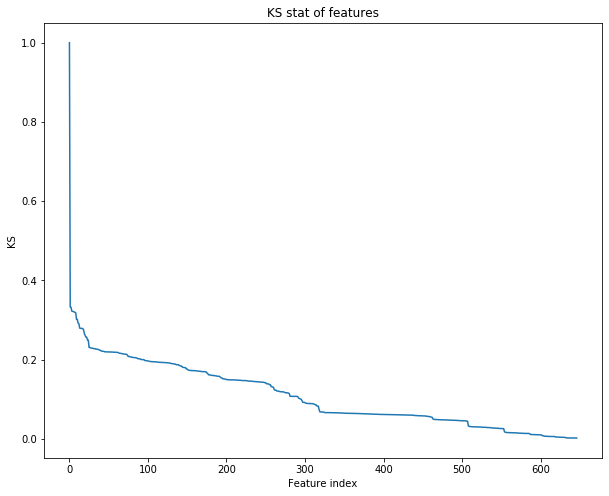

In [0]:
plt.figure(figsize=(10,8))
plt.plot(-np.sort(-KSFDR[0][:]))
plt.title("KS stat of features")
plt.ylabel('KS')
plt.xlabel('Feature index')
# plt.savefig("KS_HW5.png", dpi=200)
plt.show()

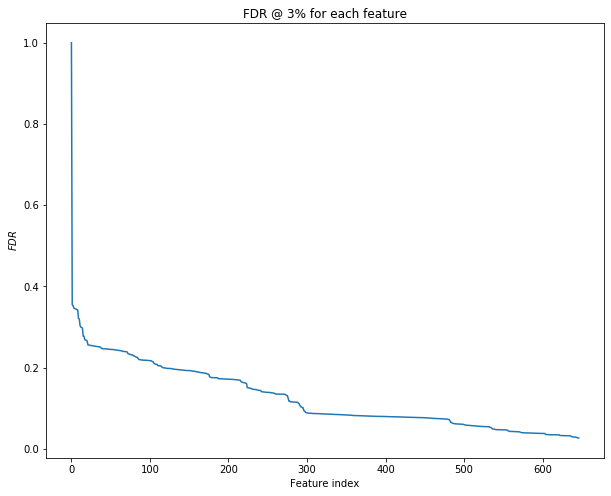

In [0]:
plt.figure(figsize=(10,8))
plt.plot(-np.sort(-KSFDR[1][:]))
plt.title("FDR @ 3% for each feature")
plt.ylabel('$FDR$')
plt.xlabel('Feature index')
plt.savefig("FDR_at_3.png", dpi=200)
plt.show()

Aggregated results with ranking for filter method

In [0]:
col_name_red = data_Jan14.columns
res_df_prof = pd.DataFrame.from_dict({'KS':KSFDR[0][:],'FDR':KSFDR[1][:]},orient='index',
                       columns=col_name_red)

In [0]:
res_df_prof = res_df_prof.transpose()
res_df_prof['Avg'] = res_df_prof.mean(axis = 1)
res_df_prof['KS Rank'] = res_df_prof['KS'].rank(ascending = False)
res_df_prof['FDR Rank'] = res_df_prof['FDR'].rank(ascending=False)
res_df_prof['Average Rank'] = res_df_prof[['KS Rank','FDR Rank']].mean(axis = 1)
res_df_prof_filter = res_df_prof.sort_values(by='Average Rank',ascending=True)
# res_df_filter = res_df_filter.drop(columns='rank_avg')
res_df_prof_filter

KS       FDR       Avg  KS Rank  FDR Rank  Average Rank
fraud_label                              1.000000  1.000000  1.000000      1.0       1.0          1.00
address_velocity30_date                  0.332725  0.353300  0.343012      2.0       3.0          2.50
address-zip_velocity30_date              0.332032  0.354954  0.343493      3.0       2.0          2.50
address_velocity14_date                  0.322252  0.345812  0.334032      4.0       5.0          4.50
address_velocity90_date                  0.321087  0.346857  0.333972      6.0       4.0          5.00
...                                           ...       ...       ...      ...       ...           ...
phonessn_diff                            0.003577  0.032561  0.018069    629.0     635.0        632.00
ssn_diff                                 0.003442  0.032648  0.018045    632.0     632.5        632.25
ssn-address-zip_velocity0_date           0.001774  0.034825  0.018299    647.0     618.0        632.50
address-zip-fullname-dob_velocity0_date  0.001813  0.034738  0.018276    644.0     621.5        632.75
ssn-homephone_velocity0_date             0.001793  0.034738  0.018265    645.0     621.5        633.25

[647 rows x 6 columns]

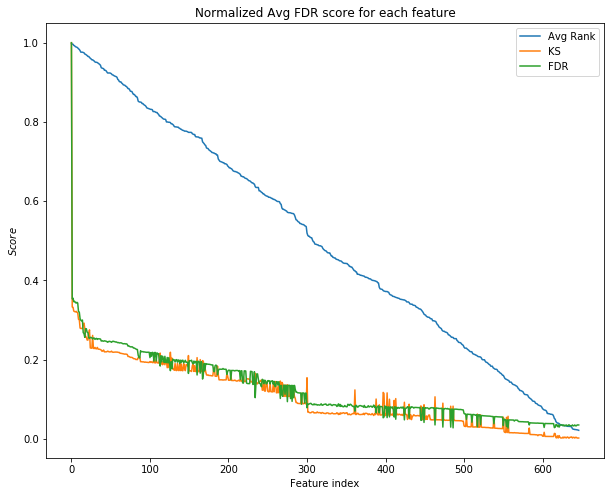

In [0]:
plt.figure(figsize=(10,8))
# plt.plot(KSFDR[1][:])
plt.plot(1-res_df_prof_filter['Average Rank'].values/res_df_prof_filter.shape[0],label = 'Avg Rank')
plt.plot(res_df_prof_filter['KS'].values,label = 'KS')
plt.plot(res_df_prof_filter['FDR'].values,label = 'FDR')
plt.title("Normalized Avg FDR score for each feature")
plt.ylabel('$Score$')
plt.xlabel('Feature index')
plt.legend()
# plt.savefig("Avg_Score.png", dpi=200)
plt.show()

### Filter method Results  
We take the top 100 features from the filter method

In [0]:
Y_labels = data_Jan14['fraud_label']
features_chosen_filter = res_df_prof_filter.index.values[1:101] #1st column is the fraud label
features_chosen_filter

In [0]:
X_data = data_Jan14[features_chosen_filter]
print(X_data.shape)
X_data.head()

(794996, 100)


address_velocity30_date  address-zip_velocity30_date  address_velocity14_date  address_velocity90_date  address-zip_velocity90_date  address-zip_velocity14_date  address_velocity180_date  address-zip_velocity180_date  address_velocity7_date  address-zip_velocity7_date  address_0_dayvel_div_14_dayvel_relvelocity  address_velocity3_date  address-zip_velocity3_date  address-zip_0_dayvel_div_14_dayvel_relvelocity  address-zip_0_dayvel_div_30_dayvel_relvelocity  address_0_dayvel_div_30_dayvel_relvelocity  address_0_dayvel_div_90_dayvel_relvelocity  address_0_dayvel_div_7_dayvel_relvelocity  address-zip_0_dayvel_div_7_dayvel_relvelocity  address_velocity1_date  address-zip_velocity1_date  address_0_dayvel_div_180_dayvel_relvelocity  address-zip_0_dayvel_div_90_dayvel_relvelocity  zip-homephone_velocity30_date  address-zip-homephone_velocity30_date  ssn-dob_velocity30_date  address-zip_0_dayvel_div_180_dayvel_relvelocity  lastname-dob_velocity30_date  fullname-dob_velocity30_date  \
38511                -0.117706                    -0.101958                -0.088541                -0.182093                    -0.167898                    -0.079045                 -0.210277                     -0.222752               -0.072633                   -0.067095                                    0.148454               -0.060819                   -0.057932                                        0.131798                                        0.179774                                     0.19994                                    0.308759                                   0.114765                                       0.102312               -0.051076                   -0.049665                                     0.390612                                        0.286272                      -0.096048                              -0.094955                -0.092879                                         0.368214                     -0.098348                     -0.093165   
38512                -0.117706                    -0.101958                -0.088541                -0.182093                    -0.167898                    -0.079045                 -0.210277                     -0.222752               -0.072633                   -0.067095                                    0.148454               -0.060819                   -0.057932                                        0.131798                                        0.179774                                     0.19994                                    0.308759                                   0.114765                                       0.102312               -0.051076                   -0.049665                                     0.390612                                        0.286272                      -0.096048                              -0.094955                -0.092879                                         0.368214                     -0.098348                     -0.093165   
38513                -0.117706                    -0.101958                -0.088541                -0.182093                    -0.167898                    -0.079045                 -0.210277                     -0.222752               -0.072633                   -0.067095                                    0.148454               -0.060819                   -0.057932                                        0.131798                                        0.179774                                     0.19994                                    0.308759                                   0.114765                                       0.102312               -0.051076                   -0.049665                                     0.390612                                        0.286272                      -0.096048                              -0.094955                -0.092879                                         0.368214                     -0.098348                     -0.093165   
38514          

## Wrapper Method

We chose the top 100 features from the wraper method

In [0]:
print('Memory percentage used',psutil.virtual_memory().percent)

Memory percentage used 81.8


### Recursive Feature Elimination  
Recursive feature elimination using logistic regression with FDR @ 3% metric

In [0]:
# creates FDR 3% metric to integrate with sklearn 
from sklearn.metrics import make_scorer
def custom_FDR(y_true, y_scores):
    res_df = pd.DataFrame({'score':y_scores,'label': y_true}).sort_values(by='score',ascending=False)
    top3_res1 = res_df.head(round(y_true.shape[0]*0.03))
    return (top3_res1['label'].sum()/sum(y_true))

my_fdr_metric = make_scorer(custom_FDR, greater_is_better=True,needs_proba = True)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from warnings import filterwarnings # this is to ignore convergence warnings
filterwarnings('ignore')

start_time = pd.datetime.now()
print("started at ",start_time)

log_reg = LogisticRegression()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv_logreg = RFECV(estimator=log_reg, step=1, cv=StratifiedKFold(2),min_features_to_select=30,
              scoring=my_fdr_metric,n_jobs=-1)
rfecv_logreg.fit(X_data, Y_labels)
print('duration: ', pd.datetime.now() - start_time)

print("Number of features chosen: %d" % rfecv_logreg.n_features_)

started at  2020-05-13 21:54:21.111047
duration:  0:19:45.027942
Optimal number of features : 39


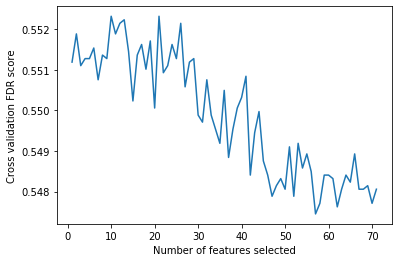

['address-zip_velocity30_date'
 'address-zip_0_dayvel_div_7_dayvel_relvelocity'
 'address-zip_velocity1_date'
 'address_0_dayvel_div_180_dayvel_relvelocity'
 'zip-homephone_velocity30_date' 'address-zip-homephone_velocity30_date'
 'ssn-dob_velocity30_date'
 'address-zip_0_dayvel_div_180_dayvel_relvelocity'
 'fullname-dob_velocity30_date' 'ssn-fullname-dob_velocity30_date'
 'ssn-firstname_velocity30_date' 'ssn-lastname_velocity30_date'
 'fullname-ssn_velocity30_date' 'ssn-dob_velocity90_date'
 'ssn-dob_velocity180_date' 'address-zip-homephone_velocity180_date'
 'fullname-dob_velocity90_date' 'firstname-dob_velocity90_date'
 'ssn-fullname-dob_velocity90_date' 'ssn-lastname_velocity180_date'
 'ssn-firstname_velocity180_date' 'ssn-lastname_velocity90_date'
 'fullname-ssn_velocity90_date' 'ssn-fullname-dob_velocity180_date'
 'fullname-ssn_velocity180_date' 'lastname-dob_velocity14_date'
 'firstname-dob_velocity14_date' 'ssn-dob_velocity14_date'
 'ssn-lastname_velocity14_date'
 'fullname-dob

In [0]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation FDR score")
plt.plot(range(1, len(rfecv_logreg.grid_scores_) + 1), rfecv_logreg.grid_scores_)
plt.show()

#---------------------save to dataframes -----------------------------
var_selected = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfecv_logreg.ranking_), X_data)),
                            columns = ['ranking', 'variable'])
# var_selected.to_csv('fs_logreg_ranks.csv')

scores_csv = pd.DataFrame(rfecv_logreg.grid_scores_,columns = ['Score'])
# scores_csv.to_csv('fs_logreg_scores.csv')

features_chosen_wrapper = X_data.columns[rfecv_logreg.support_].values
print(features_chosen_wrapper)

In [0]:
# dataframe with RFECV ranking results
var_selected.head()

ranking                                           variable
0        1  address-zip-homephone_0_dayvel_div_30_dayvel_r...
1        1             address-zip-homephone_velocity180_date
2        1              address-zip-homephone_velocity30_date
3        1               address-zip-homephone_velocity7_date
4        1    address-zip_0_dayvel_div_180_dayvel_relvelocity

#### Run recursive feature elimination (RFE) without CV for better ranking

In [0]:
from sklearn.feature_selection import RFE

start_time = pd.datetime.now()
print("started at ",start_time)

log_reg = LogisticRegression()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfe_logreg = RFE(estimator=log_reg, step=1, n_features_to_select=1)
rfe_logreg.fit(X_data[features_chosen_wrapper], Y_labels)
end_time = pd.datetime.now()
print('duration: ', end_time - start_time)

started at  2020-05-14 02:15:33.806556
duration:  0:03:39.903815


In [0]:
#---------------------split cell-----------------------------
var_selected_rfe = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfe_logreg.ranking_), X_data[features_chosen_wrapper])),
                            columns = ['ranking', 'variable'])
# var_selected_rfe.to_csv('fs_logreg_ranks91.csv')

#---------------------split cell-----------------------------
selected_columns_rfe = X_data[features_chosen_wrapper].columns[rfe_logreg.support_].values
print(selected_columns_rfe)

['ssn-lastname_velocity180_date']


In [0]:
var_selected_rfe

ranking                                           variable
0         1                      ssn-lastname_velocity180_date
1         2                      fullname-ssn_velocity180_date
2         3                     ssn-firstname_velocity180_date
3         4                        address-zip_velocity30_date
4         5                       fullname-dob_velocity30_date
5         6    fullname-dob_0_dayvel_div_30_dayvel_relvelocity
6         7                      firstname-dob_velocity14_date
7         8   firstname-dob_0_dayvel_div_14_dayvel_relvelocity
8         9                           ssn-dob_velocity180_date
9        10                  ssn-fullname-dob_velocity180_date
10       11                   ssn-fullname-dob_velocity30_date
11       12                       fullname-ssn_velocity90_date
12       13                       ssn-lastname_velocity90_date
13       14  ssn-fullname-dob_0_dayvel_div_30_dayvel_relvel...
14       15                            ssn-dob_velocity14_date
15       16         ssn-dob_0_dayvel_div_14_dayvel_relvelocity
16       17                      ssn-firstname_velocity30_date
17       18                           homephone_velocity3_date
18       19             ssn_0_dayvel_div_30_dayvel_relvelocity
19       20                       ssn-lastname_velocity30_date
20       21                       ssn-lastname_velocity14_date
21       22                            ssn-dob_velocity30_date
22       23                         address-zip_velocity1_date
23       24                       fullname-ssn_velocity30_date
24       25                       fullname-dob_velocity90_date
25       26             address-zip-homephone_velocity180_date
26       27              address-zip-homephone_velocity30_date
27       28                            ssn-dob_velocity90_date
28       29                   ssn-fullname-dob_velocity90_date
29       30               address-zip-homephone_velocity7_date
30       31                      zip-homephone_velocity30_date
31       32                       zip-homephone_velocity7_date
32       33  address-zip-homephone_0_dayvel_div_30_dayvel_r...
33       34      address-zip_0_dayvel_div_7_dayvel_relvelocity
34       35    address-zip_0_dayvel_div_180_dayvel_relvelocity
35       36        address_0_dayvel_div_180_dayvel_relvelocity
36       37                       lastname-dob_velocity14_date
37       38    lastname-dob_0_dayvel_div_14_dayvel_relvelocity
38       39                      firstname-dob_velocity90_date

In [0]:
# choose the top 30 features from the RFE method
final_wrapper_columns = var_selected_rfe.variable.values[:30]
final_wrapper_columns

array(['ssn-lastname_velocity180_date', 'fullname-ssn_velocity180_date',
       'ssn-firstname_velocity180_date', 'address-zip_velocity30_date',
       'fullname-dob_velocity30_date',
       'fullname-dob_0_dayvel_div_30_dayvel_relvelocity',
       'firstname-dob_velocity14_date',
       'firstname-dob_0_dayvel_div_14_dayvel_relvelocity',
       'ssn-dob_velocity180_date', 'ssn-fullname-dob_velocity180_date',
       'ssn-fullname-dob_velocity30_date', 'fullname-ssn_velocity90_date',
       'ssn-lastname_velocity90_date',
       'ssn-fullname-dob_0_dayvel_div_30_dayvel_relvelocity',
       'ssn-dob_velocity14_date',
       'ssn-dob_0_dayvel_div_14_dayvel_relvelocity',
       'ssn-firstname_velocity30_date', 'homephone_velocity3_date',
       'ssn_0_dayvel_div_30_dayvel_relvelocity',
       'ssn-lastname_velocity30_date', 'ssn-lastname_velocity14_date',
       'ssn-dob_velocity30_date', 'address-zip_velocity1_date',
       'fullname-ssn_velocity30_date', 'fullname-dob_velocity90_date',
 

# Model Inputs

In [0]:
# Inputs for models
X_models = X_data[final_wrapper_columns] # training set
Y_labels #labels
X_oot = df_oot[final_wrapper_columns] #OOT set
Y_oot = df_oot['fraud_label']

In [0]:
print('Memory percentage used',psutil.virtual_memory().percent)

# Logistic Regression

Logistic regression with 10-fold stratified cross validation 

Outputs 3% FDR for Train & Test sets for each fold repetition

In [0]:
# creates FDR 3% metric to integrate with sklearn 
from sklearn.metrics import make_scorer
def custom_FDR(y_true, y_scores):
    res_df = pd.DataFrame({'score':y_scores,'label': y_true}).sort_values(by='score',ascending=False)
    top3_res1 = res_df.head(round(y_true.shape[0]*0.03))
    return (top3_res1['label'].sum()/sum(y_true))

my_fdr_metric = make_scorer(custom_FDR, greater_is_better=True,needs_proba = True)

In [0]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(C=0.1,penalty='l2',solver="liblinear",tol=1e-4)#,class_weight={0:1,1:15})

current_model = lgr
cv_scores = cross_validate(current_model, X_models,Y_labels, cv=StratifiedKFold(10), scoring = my_fdr_metric,
                           return_train_score=True,return_estimator=True, n_jobs=-1)


print('Cross validation FDR scores for',type(current_model).__name__)
print('Train:',cv_scores['train_score'])
print('Test:',cv_scores['test_score'])

print('Average train score:',np.mean(cv_scores['train_score']))
print('Average test score:',np.mean(cv_scores['test_score']))

OOT FDR @ 3% for each model fitted by cross validation

In [0]:
for i_model in range(0,cv_scores['fit_time'].shape[0]):
    y_est_oot = cv_scores['estimator'][i_model].predict_proba(X_oot)
    print('OOT FDR score for',type(current_model).__name__ ,str(i_model+1),':',get_FDR(y_est_oot[:,1],Y_oot))

In this part we manually tested different parameters for the Logistic Regression model

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)

In [0]:
#Logistic regression model build with Cross Validation
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=10,Cs=[0.01]).fit(X_train, y_train)
#get model accuracy on TRN
clf.score(X_train, y_train)

Compute FDR:

Train

In [0]:
#get probability on y for TRN
prob1 = clf.predict_proba(X_train)
p1 = prob1[:,1]

In [0]:
#build a dataframe for TRN with prob(descending) and original Fraud label
df_train = X_train
df_train['prob'] = p1
df_train['org'] = y_train
df_train.sort_values(by=['prob'],ascending = False, inplace = True)
df_train.head()

In [0]:
#FDR 3% for TRN
bads1 = df_train[df_train['org'] == 1]
numbads1 = len(bads1)

topRows1 = int(round(len(df_train)*0.03))
temp1 = df_train.head(topRows1)
needed1 = temp1.loc[:,'org']
FDR1 = sum(needed1)/numbads1

print('Train FDR is ',FDR1)

Test

In [0]:
#get model accuracy on TEST
clf.score(X_test, y_test)

In [0]:
#get probability on y for TEST
prob2 = clf.predict_proba(X_test)
p2 = prob2[:,1]

In [0]:
#build a dataframe for TEST with prob(descending) and original Fraud label
df_test = X_test
df_test['prob'] = p2
df_test['org'] = y_test
df_test.sort_values(by=['prob'],ascending = False, inplace = True)
df_test.head()

In [0]:
#FDR 3% for TEST
bads2 = df_test[df_test['org'] == 1]
numbads2 = len(bads2)
topRows2 = int(round(len(df_test)*0.03))
temp2 = df_test.head(topRows2)
needed2 = temp2.loc[:,'org']

FDR2 = sum(needed2)/numbads2
print('Test FDR is ',FDR2)

OOT

In [0]:
#get model accuracy on OOT
clf.score(X_oot, Y_oot)

In [0]:
#get probability on y for OOT
# p3=[]
prob3 = clf.predict_proba(X_oot)
# for probabilty in prob3:
    # p3.append(probabilty[1])
p3 =  prob3[:,1]

In [0]:
#build a dataframe for OOT with prob(descending) and original Fraud label
df_OOT = copy.deepcopy(X_oot)
df_OOT['prob'] = p3
df_OOT['org'] = Y_oot
df_OOT.sort_values(by=['prob'],ascending = False, inplace = True)
df_OOT.head()

In [0]:
#FDR 3% for OOT
bads3 = df_OOT[df_OOT['org'] == 1]
numbads3 = len(bads3)
topRows3 = int(round(len(df_OOT)*0.03))
temp3 = df_OOT.head(topRows3)
needed3 = temp3.loc[:,'org']
FDR3 = sum(needed3)/numbads3

print('OOT FDR is ',FDR3)

# Neural Network

In [0]:
#  function to compute FDR 
def get_FDR(y_scores, y_true):
    res_df = pd.DataFrame({'score':y_scores,'label': y_true}).sort_values(by='score',ascending=False)
    top3_res1 = res_df.head(round(y_true.shape[0]*0.03))
    top3_res2 = res_df.tail(round(y_true.shape[0]*0.03))
#     return np.maximum((top3_res1['label'].sum()/sum(y_true)),(top3_res1['label'].sum()/sum(y_true)))
    return (top3_res1['label'].sum()/sum(y_true))

In [0]:
import keras.backend as K
import tensorflow as tf

def recall_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

num_hidden = 30 # number of nodes in hidden layer
adam_par = Adam(learning_rate= 0.01, beta_1=0.9, beta_2=0.999, amsgrad=False) # adam algorithm parameters


model = Sequential()
model.add(Dense(num_hidden, input_dim=X_models.shape[1], activation='relu'))
# uncomment to add extra hidden layers
# model.add(Dense(20, input_dim=12, activation='relu'))
# model.add(Dense(15, input_dim=30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_score, precision_m, recall_m, tf.keras.metrics.AUC()])


In [0]:
no_of_epochs = 3
batch = 1000 # assign batch size in training
class_weights = {0: 0.5, 1: 8.5} # assign class weight
start_time = pd.datetime.now()
history = model.fit(x=X_models, y=Y_labels, batch_size = batch,class_weight = class_weights, epochs = no_of_epochs, validation_split = 0.3)
print('duration: ', pd.datetime.now() - start_time)

In [0]:
clas_pred_train = model.predict(X_models) # get class scores
clas_pred_OOT =  model.predict(X_oot) # get class scores
print('Train FDR @ 3% is',get_FDR(np.squeeze(clas_pred),Y_labels))
print('OOT FDR is:',get_FDR(np.squeeze(clas_pred_OOT),Y_oot))   # add oot labels

### Plots of Accuracy, AUC & Loss per epoch

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# plot ROC per epoch
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('AOC per epoch')
plt.xlabel('Epochs')
plt.show()

In [0]:
# Plot training & validation loss values per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Plot the model architecture

In [0]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)

# Boosted Trees

In [0]:
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold, StratifiedKFold, cross_val_score, cross_val_predict


In [0]:
# Create Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X_models, Y_labels, test_size=0.3, train_size=0.7)

In [0]:
# Determine the ratio between the negative and positive classes to use with the scale_pos_weight parameter in XGBoost
sum_pos = sum(y_train== 1.0)
print(sum_pos)
sum_neg = sum(y_train== 0.0)
print(sum_neg)
ratio = sum_neg / sum_pos
print(ratio)

10147
689853
67.98590716467922


In [0]:
# Instantiate the XGBoost model (XGBClassifier) so that we use it with our data
# https://medium.com/@jmcneilkeller/a-complete-classification-project-part-9-feature-selection-52f746370f0c
# https://xgboost.readthedocs.io/en/latest/parameter.html

# xgbClass =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.01, n_estimators=800, max_depth=6, scale_pos_weight=ratio)
xgbClass =  XGBClassifier(objective='binary:logistic')

gbc = GradientBoostingClassifier()

In [0]:
# Define the parameters to use with GridSearchCV
parameters_xgb = {
    'max_depth': range (4, 8, 1),
    'n_estimators': range(800, 1500, 200),
    'eta': [0.1, 0.01, 0.001, 0.2, 0.3],
    'scale_pos_weight':[ratio, 1], 
}

In [0]:
# Run GridSearchCV for a boosted tree algorithm
xgb_gsCV = GridSearchCV(
    estimator=xgbClass,
    param_grid=parameters_xgb,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 2,
    verbose=True
)

In [0]:
start_xgbfit=pd.datetime.now()
xgb_gsCV.fit(X_train,y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

Fitting 2 folds for each of 64 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 59.7min
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed: 224.2min finished


DONE! 4:01:31.648245


In [0]:
# print the best estimator from GridSearchCV
xgb_gsCV.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.01477957373557601,
              seed=None, silent=None, subsample=1, verbosity=1)

In [0]:
# print the best parameters from GridSearchCV
xgb_gsCV.best_params_

{'eta': 0.1, 'max_depth': 6, 'n_estimators': 1000}

In [0]:
# output the grid search CV results to a csv file
df_xgb_gsCV = pd.DataFrame.from_dict(xgb_gsCV.cv_results_)
# df_xgb_gsCV.to_csv("df_xgb_gsCV.csv")

In [0]:
# View gridSearch CV results
df_xgb_gsCV.sort_values('rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_eta param_max_depth param_n_estimators                                             params  split0_test_score  split1_test_score  mean_test_score  std_test_score  rank_test_score
31    1386.755927     10.816632        27.546608        1.277331      0.01               6               1000  {'eta': 0.01, 'max_depth': 6, 'n_estimators': ...           0.989660           0.989836         0.989748        0.000088                1
47    1372.338441      0.490635        26.602365        1.206347     0.001               6               1000  {'eta': 0.001, 'max_depth': 6, 'n_estimators':...           0.989660           0.989836         0.989748        0.000088                1
15    1402.840367     20.087639        23.702411        2.738587       0.1               6               1000  {'eta': 0.1, 'max_depth': 6, 'n_estimators': 1...           0.989660           0.989836         0.989748        0.000088                1
63     988.165556      2.056438        12.175195        0.608607      0.03               6               1000  {'eta': 0.03, 'max_depth': 6, 'n_estimators': ...           0.989660           0.989836         0.989748        0.000088                1
27    1266.022478      8.725523        20.707657        0.696592      0.01               5               1000  {'eta': 0.01, 'max_depth': 5, 'n_estimators': ...           0.989682           0.989793         0.989738        0.000056                5
43    1264.481920      0.674582        19.719268        0.063076     0.001               5               1000  {'eta': 0.001, 'max_depth': 5, 'n_estimators':...           0.989682           0.989793         0.989738        0.000056                5
11    1251.509983     15.645363        25.074892        0.953702       0.1               5               1000  {'eta': 0.1, 'max_depth': 5, 'n_estimators': 1...           0.989682           0.989793         0.989738        0.000056                5
59    1251.190455      1.302172        19.476198        1.666064      0.03               5               1000  {'eta': 0.03, 'max_depth': 5, 'n_estimators': ...           0.989682           0.989793         0.989738        0.000056                5
46    1123.414586     14.853112        19.562619        1.740797     0.001               6                800  {'eta': 0.001, 'max_depth': 6, 'n_estimators':...           0.989642           0.989765         0.989703        0.000061                9
30    1117.876305      8.840691        18.417526        1.442322      0.01               6                800  {'eta': 0.01, 'max_depth': 6, 'n_estimators': ...           0.989642           0.989765         0.989703        0.000061                9
14    1093.222583     13.894578        19.628337        0.722670       0.1               6                800  {'eta': 0.1, 'max_depth': 6, 'n_estimators': 800}           0.989642           0.989765         0.989703        0.000061                9
62     968.438518     15.649784        11.725000        0.080900      0.03               6                800  {'eta': 0.03, 'max_depth': 6, 'n_estimators': ...           0.989642           0.989765         0.989703        0.000061                9
42     982.884779      2.678326        17.989223        0.416525     0.001               5                800  {'eta': 0.001, 'max_depth': 5, 'n_estimators':...           0.989642           0.989739         0.989691        0.000048               13
10    1007.065719      1.724184        16.362137        1.612473       0.1               5                800  {'eta': 0.1, 'max_depth': 5, 'n_estimators': 800}           0.989642           0.989739         0.989691        0.000048               13
26     994.758751      4.109844        15.766289        0.079691      0.01               5                800  {'eta': 0.01, 'max_depth': 5, 'n_estimators': ...           0.989642           0.989739         0.989691        0.000048               13
58     988.324076   

In [0]:
# Obtain the tng score/accuracy when trained with the features GridSearchCV selected
tng_score_xgb_gsCV = xgb_gsCV.score(X_train, y_train)
tng_score_xgb_gsCV

0.9898040780094053

In [0]:
# # Obtain the test score/accuracy when trained with the features GridSearchCV selected
test_score_xgb_gsCV = xgb_gsCV.score(X_test, y_test)
# # test_score_list.append(test_score)
test_score_xgb_gsCV

0.9899328718359406

In [0]:
# Obtain the OOT score/accuracy when trained with the features GridSearchCV selected
oot_score_xgb_gsCV = xgb_gsCV.score(X_oot, Y_oot)
oot_score_xgb_gsCV

0.9896512165676635

## Run XGBoost
Run XGBoost with different parameters and analyze the output

In [0]:
def fdr_XGB(data, topRows):
    topRows_fs = int(round(len(data)*topRows))
    data_topRows = data.head(topRows_fs)
    frauds_current = data_topRows.loc[:,'fraud_label']
    bads_all = data.loc[data['fraud_label'] == 1]
    FDR = sum(frauds_current) / len(bads_all)
    return FDR

In [0]:
def make_data(model, X_data, y_data):
    fraud_proba = model.predict_proba(X_data)[:, 1]
    curr_data = X_data.copy()
    curr_data.insert(0, 'fraud_label', y_data)
    curr_data.insert(1, 'fraud_proba', fraud_proba)
    curr_data = curr_data.sort_values(['fraud_proba'], ascending=False)
    return curr_data

In [0]:
start_xgbfit=pd.datetime.now()
xgb_1 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.01, 
                           n_estimators=600, max_depth=5, scale_pos_weight=ratio)
xgb_1.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:07:59.189273


In [0]:
start_xgbfit=pd.datetime.now()
xgb_2 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.01, 
                           n_estimators=800, max_depth=5, scale_pos_weight=ratio)
xgb_2.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:10:31.176258


In [0]:
start_xgbfit=pd.datetime.now()
xgb_3 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.01, 
                           n_estimators=1000, max_depth=5, scale_pos_weight=ratio)
xgb_3.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:12:56.761847


In [0]:
start_xgbfit=pd.datetime.now()
xgb_4 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.01, 
                           n_estimators=600, max_depth=4, scale_pos_weight=ratio)
xgb_4.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:06:40.565662


In [0]:
start_xgbfit=pd.datetime.now()
xgb_5 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.01, 
                           n_estimators=800, max_depth=4, scale_pos_weight=ratio)
xgb_5.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:08:51.674261


In [0]:
start_xgbfit=pd.datetime.now()
xgb_6 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.01, 
                           n_estimators=1000, max_depth=4, scale_pos_weight=ratio)
xgb_6.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:11:05.207002


In [0]:
start_xgbfit=pd.datetime.now()
xgb_7 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.001, 
                           n_estimators=600, max_depth=5, scale_pos_weight=ratio)
xgb_7.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:07:45.501011


In [0]:
start_xgbfit=pd.datetime.now()
xgb_8 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.001, 
                           n_estimators=800, max_depth=5, scale_pos_weight=ratio)
xgb_8.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:10:19.677419


In [0]:
start_xgbfit=pd.datetime.now()
xgb_9 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.001, 
                           n_estimators=1000, max_depth=5, scale_pos_weight=ratio)
xgb_9.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:12:56.165312


In [0]:
start_xgbfit=pd.datetime.now()
xgb_10 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.001, 
                           n_estimators=600, max_depth=4, scale_pos_weight=ratio)
xgb_10.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:06:40.209160


In [0]:
start_xgbfit=pd.datetime.now()
xgb_11 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.001, 
                           n_estimators=800, max_depth=4, scale_pos_weight=ratio)
xgb_11.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:08:56.770541


In [0]:
start_xgbfit=pd.datetime.now()
xgb_12 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.001, 
                           n_estimators=1000, max_depth=4, scale_pos_weight=ratio)
xgb_12.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:11:08.132761


In [0]:
start_xgbfit=pd.datetime.now()
xgb_13 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.01, 
                           n_estimators=600, max_depth=6, scale_pos_weight=ratio)
xgb_13.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:11:51.525173


In [0]:
start_xgbfit=pd.datetime.now()
xgb_14 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.01, 
                           n_estimators=800, max_depth=6, scale_pos_weight=ratio)
xgb_14.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:16:51.773824


In [0]:
start_xgbfit=pd.datetime.now()
xgb_15 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.01, 
                           n_estimators=1000, max_depth=6, scale_pos_weight=ratio)
xgb_15.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:16:35.006191


In [0]:
start_xgbfit=pd.datetime.now()
xgb_16 =  xgb.XGBClassifier(objective='binary:logistic', learning_rate = 0.01, 
                           n_estimators=1200, max_depth=6, scale_pos_weight=ratio)
xgb_16.fit(X_train, y_train)
print("DONE!", pd.datetime.now()-start_xgbfit)

DONE! 0:20:10.236810


### Analyze the Results
Analyze the results from the various boosted tree models. They are stored in results_dict.

In [0]:
time_results=pd.datetime.now()

results_dict_XGB={}
for num in range(1,17):
    curr_time=pd.datetime.now()
    curr_model_name = "xgb_" + str(num)
    
    results_dict_XGB[curr_model_name]={'scores':{},
                                   'data':{},
                                   'FDR':{}
                                  }
    
    # Calculate the accuracy scores of the model 
    train_score = vars()[curr_model_name].score(X_train, y_train)
    test_score = vars()[curr_model_name].score(X_test, y_test)
    oot_score = vars()[curr_model_name].score(X_oot, Y_oot)
    
    # Save the accuracy scores of the model
    results_dict_XGB[curr_model_name]['scores']['train_score'] = train_score
    results_dict_XGB[curr_model_name]['scores']['test_score'] = test_score
    results_dict_XGB[curr_model_name]['scores']['oot_score'] = oot_score
    
    # Calculate the ".predict_proba" and make dataframes for all datasets
    train_data = make_data(vars()[curr_model_name], X_train, y_train) 
    test_data = make_data(vars()[curr_model_name], X_test, y_test) 
    oot_data = make_data(vars()[curr_model_name], X_oot, Y_oot) 
    
    # Save all the dataframes for the model
    results_dict_XGB[curr_model_name]['data']['train_data'] = train_data
    results_dict_XGB[curr_model_name]['data']['test_data'] = test_data
    results_dict_XGB[curr_model_name]['data']['oot_data'] = oot_data
    
    # Calculate the FDRs
    train_FDR = fdr_XGB(train_data, 0.03)
    test_FDR = fdr_XGB(test_data, 0.03)
    oot_FDR = fdr_XGB(oot_data, 0.03)
    
    # Save the FDRs
    results_dict_XGB[curr_model_name]['FDR']['train_FDR'] = train_FDR
    results_dict_XGB[curr_model_name]['FDR']['test_FDR'] = test_FDR
    results_dict_XGB[curr_model_name]['FDR']['oot_FDR'] = oot_FDR
    
    print("Done with:",curr_model_name, ";  time:",pd.datetime.now()-curr_time)

print("DONE!", pd.datetime.now()-time_results)

In [0]:
for model in results_dict_XGB.keys():
    print(model)
    print(results_dict_XGB[model]['FDR'])
    print("")

# Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [0]:
#splitting training into 70:30 ratio for training and testing 
# Not using Random State here in order to see the variation in the results
X_train,X_test,Y_train,Y_test = train_test_split(X_models,Y_labels,train_size=0.7,test_size = 0.30)    

In [0]:
start = pd.datetime.now()
# Create the parameter grid 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [6, 7, 8, 9],
    'n_estimators': [300,400,500,600,700,800]
}

rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2,scoring='neg_mean_squared_error')
print(pd.datetime.now()-start)

In [0]:
start = pd.datetime.now()

# Fit grid model with training data
grid_search.fit(X_train, Y_train)

# Print the best parameters
grid_search.best_params_

print(pd.datetime.now()-start)

In [0]:
# The following models are being fitted for fine tuning the parameters by manually 
# fitting with parameters by slightly varying them around the best parameters for better test fdr

In [0]:
random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 400, max_depth=60)
random_forest_1.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
random_forest_2 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 400,max_depth=70)
random_forest_2.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
random_forest_3 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 400,max_depth=80)
random_forest_3.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
random_forest_4 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 500,max_depth=60)
random_forest_4.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
random_forest_5 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 500,max_depth=70)
random_forest_5.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
random_forest_6 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 500,max_depth=80)
random_forest_6.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
random_forest_7 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 500,max_depth=90)
random_forest_7.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
random_forest_8 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 600,max_depth=60)
random_forest_8.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
random_forest_9 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 600,max_depth=70)
random_forest_9.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
random_forest_10 = RandomForestClassifier(max_features = 7,n_estimators = 600,max_depth=80)
random_forest_10.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
random_forest_11 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 600,max_depth=90)
random_forest_11.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
random_forest_12 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 650,max_depth=80)
random_forest_12.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=650,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Random Forest Results

In [0]:
# Function to calculate Fraud detection rate at 3% depth for different models
def fdr_RF(model,X_data,Y_data):
    Y_data = pd.DataFrame(Y_data)
    Y_data['Fraud Proba'] = model.predict_proba(X_data)[:,1].tolist()
    Y_data = Y_data.sort_values(by='Fraud Proba',ascending=False)
    total_bads = Y_data['fraud_label'][Y_data['fraud_label']==1].count()
    top_rows = int(len(X_data)*.03)
    sum_bads = Y_data['fraud_label'].head(top_rows)[Y_data['fraud_label']==1].count()
    fdr = sum_bads/total_bads
    return fdr*100

In [0]:
time_results = pd.datetime.now()
results_dict_RF = {}
for i in range(1,13):
    curr_time = pd.datetime.now()
    model_name = "random_forest_"+str(i)
    results_dict_RF[model_name] = {'fdr':{}}
    
    # calculate fdr for training, testing, and validation sets
    results_dict_RF[model_name]['fdr']['train_fdr_30']=fdr_RF(vars()[model_name],X_train,Y_train)
    results_dict_RF[model_name]['fdr']['test_fdr_30']=fdr_RF(vars()[model_name],X_test,Y_test)
    results_dict_RF[model_name]['fdr']['oot_fdr_30']=fdr_RF(vars()[model_name],X_oot,Y_oot)
    
    print("Done with:",model_name, ";  time:",pd.datetime.now()-curr_time)
    
print("DONE!", pd.datetime.now()-time_results)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


Done with: random_forest_1 ;  time: 0:00:58.535585


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


Done with: random_forest_2 ;  time: 0:00:57.979901


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


Done with: random_forest_3 ;  time: 0:00:58.158208


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


Done with: random_forest_4 ;  time: 0:01:12.995941


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


Done with: random_forest_5 ;  time: 0:01:12.583308


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


Done with: random_forest_6 ;  time: 0:01:17.933517


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


Done with: random_forest_7 ;  time: 0:01:12.659784


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


Done with: random_forest_8 ;  time: 0:01:24.139886


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


Done with: random_forest_9 ;  time: 0:01:27.896470


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


Done with: random_forest_10 ;  time: 0:01:28.380382


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


Done with: random_forest_11 ;  time: 0:01:28.400079
Done with: random_forest_12 ;  time: 0:01:35.220182
DONE! 0:15:14.889182


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  from ipykernel import kernelapp as app


In [0]:
# Print the train, test, and validation set fdr results
results_dict_RF

{'random_forest_1': {'fdr': {'oot_fdr_30': 51.55071248952221,
   'test_fdr_30': 52.93955285674855,
   'train_fdr_30': 53.66173664122137}},
 'random_forest_10': {'fdr': {'oot_fdr_30': 51.46689019279128,
   'test_fdr_30': 52.85674855092465,
   'train_fdr_30': 53.69751908396947}},
 'random_forest_11': {'fdr': {'oot_fdr_30': 51.592623637887684,
   'test_fdr_30': 52.85674855092465,
   'train_fdr_30': 53.73330152671756}},
 'random_forest_12': {'fdr': {'oot_fdr_30': 51.55071248952221,
   'test_fdr_30': 52.691139939276844,
   'train_fdr_30': 53.73330152671756}},
 'random_forest_2': {'fdr': {'oot_fdr_30': 51.46689019279128,
   'test_fdr_30': 52.663538504002204,
   'train_fdr_30': 53.69751908396947}},
 'random_forest_3': {'fdr': {'oot_fdr_30': 51.46689019279128,
   'test_fdr_30': 52.691139939276844,
   'train_fdr_30': 53.76908396946565}},
 'random_forest_4': {'fdr': {'oot_fdr_30': 51.676445934618606,
   'test_fdr_30': 52.663538504002204,
   'train_fdr_30': 53.68559160305344}},
 'random_forest_5'

In [0]:
# Get the best model number with highest test fdr
for k,v in results_dict_RF.items():
  maximum_key = max(results_dict_RF, key=lambda v: results_dict_RF[v]['fdr']['test_fdr_30'])
vars()[maximum_key] 

# Final model results tables (required for project report)

In [0]:
def output_table(y_res_valid,Y_valid):
# returs the output tables
# y_res_valis is y_pred
# Y_valid is y_true
# returns:
# cumulative dataset, Bin Statistics
    no_of_bads =Y_valid.sum()
    no_of_records = len(Y_valid)
    no_of_goods = no_of_records - no_of_bads
    print('no_of_records',no_of_records)
    print('No of bads',no_of_bads)
    print('no_of_goods',no_of_goods)

    fin_tabl_df = pd.DataFrame({'score':y_res_valid,'label': Y_valid}).sort_values(by='score',ascending=False)
    df_pres_cum = pd.DataFrame(columns=['Total # Records','# Goods','# Bads'])
    for i_tbl_df in range(1,21): #21 is the final
    #     print(i_tbl_df)
        top3_res2 = fin_tabl_df.head(round(Y_valid.shape[0]*(i_tbl_df/100)))
        top3_res2#['label'].sum()/sum(Y_valid)
    #     print('No of records:',top3_res2.shape[0])
        df_pres_cum.loc[i_tbl_df-1,'Total # Records'] = top3_res2.shape[0]
    #     print('No of bads:',top3_res2['label'].sum())
        df_pres_cum.loc[i_tbl_df-1,'# Bads'] = top3_res2['label'].sum()
    #     print('No of goods:',top3_res2.shape[0]- top3_res2['label'].sum())
        df_pres_cum.loc[i_tbl_df-1,'# Goods'] = top3_res2.shape[0]- top3_res2['label'].sum()

    df_pres = df_pres_cum.diff()
    df_pres.loc[0] = df_pres_cum.loc[0]
    df_pres = df_pres.rename(columns={"Total # Records": "# Records"})
    df_pres['% Goods'] = 100*(df_pres['# Goods']/df_pres['# Records'])
    df_pres['% Bads'] = 100*(df_pres['# Bads']/df_pres['# Records'])
    print('Bin statistics')
    df_pres.to_csv(path+'Test_Bin_stats.csv')
    display(df_pres)

    df_pres_cum['% Goods'] = 100*(df_pres_cum['# Goods']/no_of_goods)
    df_pres_cum['% Bads'] = 100*(df_pres_cum['# Bads']/no_of_bads)
    df_pres_cum['KS'] = df_pres_cum['% Bads'] - df_pres_cum['% Goods']
    df_pres_cum['FPR'] = df_pres_cum['# Goods']/df_pres_cum['# Bads']
    df_pres_cum = df_pres_cum.rename(columns={"# Goods": "Cumulative Goods",'# Bads':'Cumulative Bads','% Bads':'% Bads (FDR)'})
    print('Cumulative results')
    # df_pres_cum.to_csv(path+'Test_Cum_stats.csv') To save into a csv file
    display(df_pres_cum)
    return df_pres_cum, df_pres

In [0]:
# Concatenating Fraud probability fitted with the best model with actual fraud label for calculating bin statistics
Y_train['Fraud Proba'] =  vars()[maximum_key].predict_proba(X_train)[:,1].tolist()
Y_test['Fraud Proba'] =  vars()[maximum_key].predict_proba(X_test)[:,1].tolist()
Y_oot['Fraud Proba'] =  vars()[maximum_key].predict_proba(X_oot)[:,1].tolist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
# Training Set
output_table(Y_train['Fraud Proba'],Y_train['fraud_label'])

no_of_records 583454
No of bads 8339
no_of_goods 575115
Bin statistics


# Records # Goods # Bads  % Goods    % Bads
0       5835    1592   4243  27.2836   72.7164
1       5834    5689    145  97.5146   2.48543
2       5835    5778     57  99.0231  0.976864
3       5834    5785     49  99.1601  0.839904
4       5835    5791     44  99.2459   0.75407
5       5834    5786     48  99.1772  0.822763
6       5835    5800     35  99.4002  0.599829
7       5834    5787     47  99.1944  0.805622
8       5835    5795     40  99.3145  0.685518
9       5834    5792     42  99.2801  0.719918
10      5835    5792     43  99.2631  0.736932
11      5834    5792     42  99.2801  0.719918
12      5835    5799     36   99.383  0.616967
13      5835    5785     50  99.1431  0.856898
14      5834    5784     50   99.143  0.857045
15      5835    5796     39  99.3316   0.66838
16      5834    5784     50   99.143  0.857045
17      5835    5786     49  99.1602   0.83976
18      5834    5802     32  99.4515  0.548509
19      5835    5798     37  99.3659  0.634105

Cumulative results


Total # Records Cumulative Goods Cumulative Bads   % Goods % Bads (FDR)       KS       FPR
0             5835             1592            4243  0.276814      50.8814  50.6046  0.375206
1            11669             7281            4388   1.26601      52.6202  51.3542    1.6593
2            17504            13059            4445   2.27068      53.3038  51.0331   2.93791
3            23338            18844            4494   3.27656      53.8914  50.6148   4.19315
4            29173            24635            4538   4.28349       54.419  50.1355    5.4286
5            35007            30421            4586   5.28955      54.9946  49.7051   6.63345
6            40842            36221            4621   6.29804      55.4143  49.1163   7.83835
7            46676            42008            4668   7.30428      55.9779  48.6737   8.99914
8            52511            47803            4708    8.3119      56.4576  48.1457   10.1536
9            58345            53595            4750   9.31901      56.9613  47.6423   11.2832
10           64180            59387            4793   10.3261      57.4769  47.1508   12.3904
11           70014            65179            4835   11.3332      57.9806  46.6474   13.4807
12           75849            70978            4871   12.3415      58.4123  46.0707   14.5715
13           81684            76763            4921   13.3474      59.0119  45.6645   15.5991
14           87518            82547            4971   14.3531      59.6115  45.2583   16.6057
15           93353            88343            5010   15.3609      60.0791  44.7182   17.6333
16           99187            94127            5060   16.3666      60.6787  44.3121   18.6022
17          105022            99913            5109   17.3727      61.2663  43.8936   19.5563
18          110856           105715            5141   18.3815      61.6501  43.2685   20.5631
19          116691           111513            5178   19.3897      62.0938  42.7041   21.5359

(   Total # Records Cumulative Goods Cumulative Bads   % Goods % Bads (FDR)       KS       FPR
 0             5835             1592            4243  0.276814      50.8814  50.6046  0.375206
 1            11669             7281            4388   1.26601      52.6202  51.3542    1.6593
 2            17504            13059            4445   2.27068      53.3038  51.0331   2.93791
 3            23338            18844            4494   3.27656      53.8914  50.6148   4.19315
 4            29173            24635            4538   4.28349       54.419  50.1355    5.4286
 5            35007            30421            4586   5.28955      54.9946  49.7051   6.63345
 6            40842            36221            4621   6.29804      55.4143  49.1163   7.83835
 7            46676            42008            4668   7.30428      55.9779  48.6737   8.99914
 8            52511            47803            4708    8.3119      56.4576  48.1457   10.1536
 9            58345            53595            47

In [0]:
# Testing Set
output_table(Y_test['Fraud Proba'],Y_test['fraud_label'])

no_of_records 250053
No of bads 3668
no_of_goods 246385
Bin statistics


# Records # Goods # Bads  % Goods    % Bads
0       2501     604   1897  24.1503   75.8497
1       2500    2439     61    97.56      2.44
2       2501    2480     21  99.1603  0.839664
3       2500    2482     18    99.28      0.72
4       2501    2483     18  99.2803  0.719712
5       2500    2480     20     99.2       0.8
6       2501    2489     12  99.5202  0.479808
7       2500    2480     20     99.2       0.8
8       2501    2487     14  99.4402  0.559776
9       2500    2481     19    99.24      0.76
10      2501    2482     19  99.2403  0.759696
11      2500    2484     16    99.36      0.64
12      2501    2480     21  99.1603  0.839664
13      2500    2482     18    99.28      0.72
14      2501    2489     12  99.5202  0.479808
15      2500    2479     21    99.16      0.84
16      2501    2489     12  99.5202  0.479808
17      2501    2483     18  99.2803  0.719712
18      2500    2483     17    99.32      0.68
19      2501    2482     19  99.2403  0.759696

Cumulative results


Total # Records Cumulative Goods Cumulative Bads   % Goods % Bads (FDR)       KS       FPR
0             2501              604            1897  0.245145      51.7176  51.4724  0.318397
1             5001             3043            1958   1.23506      53.3806  52.1455   1.55414
2             7502             5523            1979   2.24161      53.9531  51.7115    2.7908
3            10002             8005            1997   3.24898      54.4438  51.1949   4.00851
4            12503            10488            2015   4.25675      54.9346  50.6778   5.20496
5            15003            12968            2035   5.26331      55.4798  50.2165   6.37248
6            17504            15457            2047   6.27352       55.807  49.5335   7.55105
7            20004            17937            2067   7.28007      56.3522  49.0722   8.67779
8            22505            20424            2081   8.28947      56.7339  48.4444   9.81451
9            25005            22905            2100   9.29643      57.2519  47.9555   10.9071
10           27506            25387            2119   10.3038      57.7699  47.4661   11.9807
11           30006            27871            2135    11.312      58.2061  46.8941   13.0543
12           32507            30351            2156   12.3185      58.7786  46.4601   14.0775
13           35007            32833            2174   13.3259      59.2694  45.9435   15.1026
14           37508            35322            2186   14.3361      59.5965  45.2604   16.1583
15           40008            37801            2207   15.3422       60.169  44.8268   17.1278
16           42509            40290            2219   16.3525      60.4962  44.1437   18.1568
17           45010            42773            2237   17.3602      60.9869  43.6267   19.1207
18           47510            45256            2254    18.368      61.4504  43.0824   20.0781
19           50011            47738            2273   19.3754      61.9684   42.593   21.0022

(   Total # Records Cumulative Goods Cumulative Bads   % Goods % Bads (FDR)       KS       FPR
 0             2501              604            1897  0.245145      51.7176  51.4724  0.318397
 1             5001             3043            1958   1.23506      53.3806  52.1455   1.55414
 2             7502             5523            1979   2.24161      53.9531  51.7115    2.7908
 3            10002             8005            1997   3.24898      54.4438  51.1949   4.00851
 4            12503            10488            2015   4.25675      54.9346  50.6778   5.20496
 5            15003            12968            2035   5.26331      55.4798  50.2165   6.37248
 6            17504            15457            2047   6.27352       55.807  49.5335   7.55105
 7            20004            17937            2067   7.28007      56.3522  49.0722   8.67779
 8            22505            20424            2081   8.28947      56.7339  48.4444   9.81451
 9            25005            22905            21

In [0]:
# Validation Set
output_table(Y_oot['Fraud Proba'],Y_oot['fraud_label'])

no_of_records 166493
No of bads 2386
no_of_goods 164107
Bin statistics


# Records # Goods # Bads  % Goods    % Bads
0       1665     492   1173  29.5495   70.4505
1       1665    1619     46  97.2372   2.76276
2       1665    1657      8  99.5195   0.48048
3       1665    1652     13  99.2192  0.780781
4       1665    1657      8  99.5195   0.48048
5       1665    1653     12  99.2793  0.720721
6       1665    1654     11  99.3393  0.660661
7       1664    1646     18  98.9183   1.08173
8       1665    1651     14  99.1592  0.840841
9       1665    1651     14  99.1592  0.840841
10      1665    1657      8  99.5195   0.48048
11      1665    1645     20  98.7988    1.2012
12      1665    1655     10  99.3994  0.600601
13      1665    1654     11  99.3393  0.660661
14      1665    1655     10  99.3994  0.600601
15      1665    1655     10  99.3994  0.600601
16      1665    1652     13  99.2192  0.780781
17      1665    1655     10  99.3994  0.600601
18      1665    1649     16   99.039  0.960961
19      1665    1658      7  99.5796   0.42042

Cumulative results


Total # Records Cumulative Goods Cumulative Bads   % Goods % Bads (FDR)       KS       FPR
0             1665              492            1173  0.299804      49.1618   48.862  0.419437
1             3330             2111            1219   1.28636      51.0897  49.8033   1.73175
2             4995             3768            1227   2.29606       51.425  49.1289    3.0709
3             6660             5420            1240   3.30272      51.9698  48.6671   4.37097
4             8325             7077            1248   4.31243      52.3051  47.9927   5.67067
5             9990             8730            1260    5.3197       52.808  47.4883   6.92857
6            11655            10384            1271   6.32758      53.2691  46.9415   8.16994
7            13319            12030            1289   7.33058      54.0235  46.6929   9.33282
8            14984            13681            1303   8.33663      54.6102  46.2736   10.4996
9            16649            15332            1317   9.34268       55.197  45.8543   11.6416
10           18314            16989            1325   10.3524      55.5323  45.1799   12.8219
11           19979            18634            1345   11.3548      56.3705  45.0157   13.8543
12           21644            20289            1355   12.3633      56.7896  44.4263   14.9734
13           23309            21943            1366   13.3712      57.2506  43.8795   16.0637
14           24974            23598            1376   14.3796      57.6697  43.2901   17.1497
15           26639            25253            1386   15.3881      58.0889  42.7007   18.2201
16           28304            26905            1399   16.3948      58.6337  42.2389   19.2316
17           29969            28560            1409   17.4033      59.0528  41.6495   20.2697
18           31634            30209            1425   18.4081      59.7234  41.3153   21.1993
19           33299            31867            1432   19.4184      60.0168  40.5983   22.2535

(   Total # Records Cumulative Goods Cumulative Bads   % Goods % Bads (FDR)       KS       FPR
 0             1665              492            1173  0.299804      49.1618   48.862  0.419437
 1             3330             2111            1219   1.28636      51.0897  49.8033   1.73175
 2             4995             3768            1227   2.29606       51.425  49.1289    3.0709
 3             6660             5420            1240   3.30272      51.9698  48.6671   4.37097
 4             8325             7077            1248   4.31243      52.3051  47.9927   5.67067
 5             9990             8730            1260    5.3197       52.808  47.4883   6.92857
 6            11655            10384            1271   6.32758      53.2691  46.9415   8.16994
 7            13319            12030            1289   7.33058      54.0235  46.6929   9.33282
 8            14984            13681            1303   8.33663      54.6102  46.2736   10.4996
 9            16649            15332            13